In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mainset16/captions.txt
/kaggle/input/mainset16/Images/1002674143_1b742ab4b8.jpg
/kaggle/input/mainset16/Images/vithun.jpg
/kaggle/input/mainset16/Images/vithun1.jpg
/kaggle/input/mainset16/Images/rahul.jpg
/kaggle/input/mainset16/Images/101669240_b2d3e7f17b.jpg
/kaggle/input/mainset16/Images/1379026456_153fd8b51b.jpg
/kaggle/input/mainset16/Images/1000268201_693b08cb0e.jpg
/kaggle/input/mainset16/Images/1001773457_577c3a7d70.jpg


In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add


In [3]:
BASE_DIR = '/kaggle/input/mainset16'
WORKING_DIR = '/kaggle/working'

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())



2022-10-07 05:00:21.872533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 05:00:21.958876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 05:00:21.959705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 05:00:21.960640: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8 [00:00<?, ?it/s]

2022-10-07 05:00:30.017921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-07 05:00:31.101364: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [6]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/44 [00:00<?, ?it/s]

In [10]:
len(mapping)

8

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
         caption = captions[i]
        # preprocessing steps
        # convert to lowercase
        caption = caption.lower()
        # delete digits, special chars, etc., 
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        captions[i] = caption

In [12]:
# before preprocess of text
mapping['101669240_b2d3e7f17b']

['A man in a hat is displaying pictures next to a skier in a blue hat .',
 'A man skis past another man displaying paintings in the snow .',
 'A person wearing skis looking at framed pictures set up in the snow .',
 'A skier looks at framed pictures in the snow next to trees .',
 'Man on skis looking at artwork for sale in the snow .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['101669240_b2d3e7f17b']

['A man in a hat is displaying pictures next to a skier in a blue hat .',
 'A man skis past another man displaying paintings in the snow .',
 'A person wearing skis looking at framed pictures set up in the snow .',
 'A skier looks at framed pictures in the snow next to trees .',
 'startseq man on skis looking at artwork for sale in the snow endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40

In [17]:
all_captions[:10]

['A man in a white shirt is has a black headphone in his ear .',
 'A man in a white shirt is in front of a map .',
 '"a man listening to his iPod   looks at the subway maps ."',
 'A man with a shirt wears headphones standing in front of a directory .',
 'startseq young man is wearing white shirt and has black earphones in his ears endseq',
 'A man balances a knife on his arm as another man watches .',
 'A man has a knife on his arm and another man is watching .',
 'A man is tossing a knife in the air while another man stands nearby .',
 'A young man shows off a knife trick to another .',
 'startseq the man in the bright colored shirt is balancing knife on his arm endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

134

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

21

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length) [0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], 
                       num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    if n == batch_size:
                        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                        yield [X1, X2], y
                        X1, X2, y = list(), list(), list()
                        n = 0

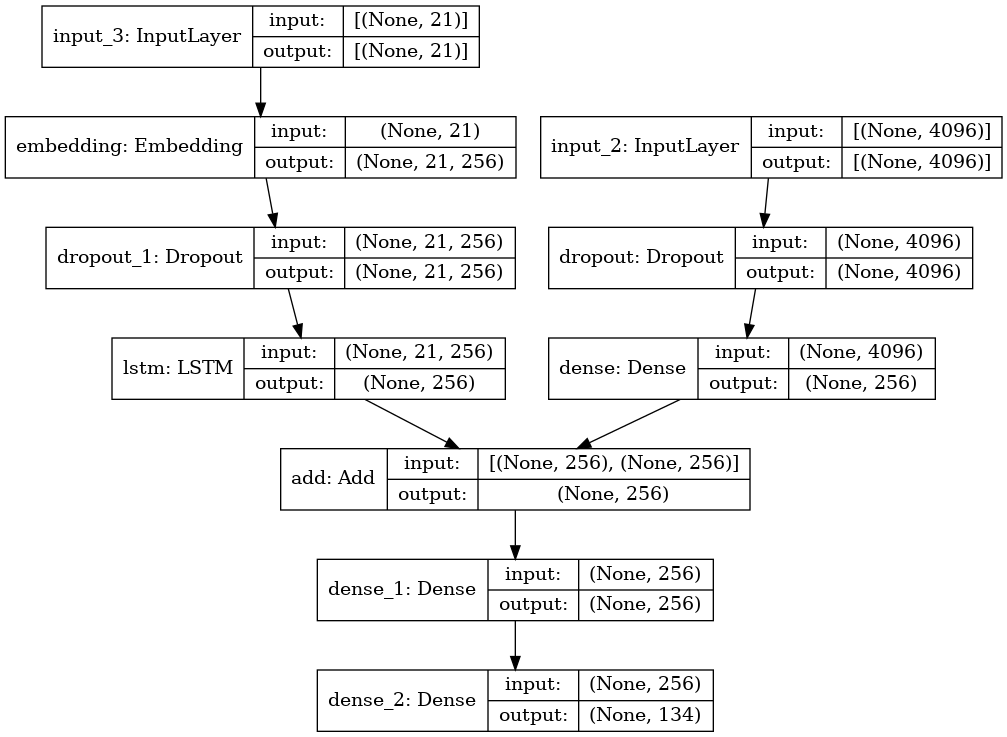

In [24]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# train the model
epochs = 200
batch_size = 7
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1/1 [==============================] - 0s 121ms/step - loss: 0.2195


In [26]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1 [00:00<?, ?it/s]

BLEU-1: 0.285714
BLEU-2: 0.148250


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [30]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
A man sits at a table in front of a computer wearing headphones .
A man with headphones on is looking at a computer screen while sitting at a table .
A young man is sitting at a table with a laptop and earphones .
A young man with headphones looking at a Macintosh laptop computer .
startseq man sitting with headphones at laptop endseq
--------------------Predicted--------------------
startseq man sitting with headphones at laptop endseq


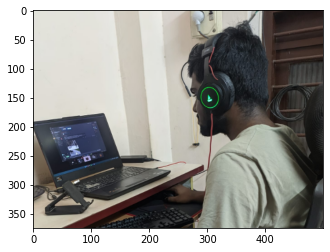

In [31]:
generate_caption("vithun.jpg")


---------------------Actual---------------------
A man balances a knife on his arm as another man watches .
A man has a knife on his arm and another man is watching .
A man is tossing a knife in the air while another man stands nearby .
A young man shows off a knife trick to another .
startseq the man in the bright colored shirt is balancing knife on his arm endseq
--------------------Predicted--------------------
startseq the man in the bright colored shirt is balancing knife on his arm endseq


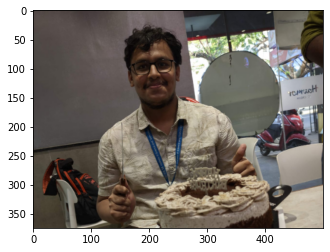

In [32]:
generate_caption("rahul.jpg")

---------------------Actual---------------------
A man in a white shirt is has a black headphone in his ear .
A man in a white shirt is in front of a map .
"a man listening to his iPod   looks at the subway maps ."
A man with a shirt wears headphones standing in front of a directory .
startseq young man is wearing white shirt and has black earphones in his ears endseq
--------------------Predicted--------------------
startseq young man is wearing white shirt and has black earphones in his ears endseq


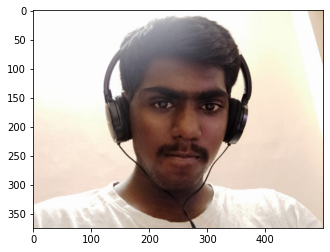

In [33]:
generate_caption("vithun1.jpg")

---------------------Actual---------------------
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq young girl with pigtails painting outside in the grass endseq


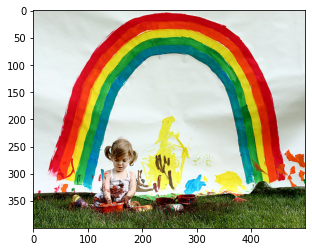

In [34]:
generate_caption("1002674143_1b742ab4b8.jpg")